In [42]:
import pandas as pd
from collections import Counter
import numpy as np
from Bio import SeqIO
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import sys
import os
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage,leaves_list
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import hamming, squareform
from scipy.spatial.distance import pdist, jaccard

BLOOD_MICROBIOME_PATH = '/home/groups/dpwall/briannac/blood_microbiome/'
fig_dir=BLOOD_MICROBIOME_PATH + 'results/abundances/'

sys.path.append('/home/groups/dpwall/briannac/blood_microbiome/src')
bam_mappings_file = '/home/groups/dpwall/briannac/general_data/bam_mappings.csv'

bacteria_file = BLOOD_MICROBIOME_PATH + 'data/kraken_align/bacteria_filtered_species.df' 
virus_file = BLOOD_MICROBIOME_PATH + 'data/kraken_align/virus_filtered_species.df' 
np.random.seed(42)

# Filter

## Load / format data

In [43]:
bam_mappings = pd.read_csv(bam_mappings_file, sep='\t', index_col=1)
df_bacteria = pd.read_pickle(bacteria_file)
df_virus  = pd.read_pickle(virus_file)

In [44]:
df_virus.index = [i[2] for i in df_virus.index]
df_bacteria.index = [i[2] for i in df_bacteria.index]
df_virus = df_virus.transpose()
df_bacteria = df_bacteria.transpose()

# Microbe Abundance Plots
## Virus

In [45]:
virus_abundant = df_virus.columns[np.argsort(df_virus.sum())[::-1]][:50]
virus_prevalent = []#df_virus.columns[np.argsort((df_virus>0).sum())[::-1]][:25]
select_viruses = list(set(virus_abundant).union(set(virus_prevalent)))
len(select_viruses)

50

In [46]:
# Hacky way to make cylical color palette.
a=np.concatenate([[tuple(i) for i in sns.color_palette("husl", 34)[n::5]] for n in range(5)])
a = [tuple(i) for i in a]
palette = ['#%02x%02x%02x' % (int(i[0]*255), int(i[1]*255), int(i[2]*255)) for i in a]
hierarchy.set_link_color_palette(palette)

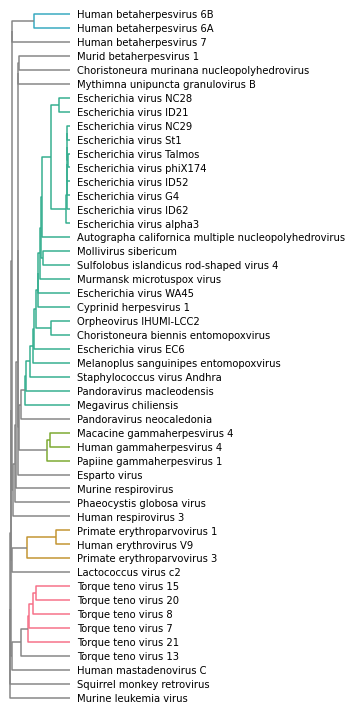

In [47]:
dists = 1-df_virus[select_viruses].corr('spearman')#pdist(df_bacteria.transpose(), 'braycurtis')
linkage_mat = linkage(squareform(dists))#, 'ward')
virus_order = df_virus[select_viruses].columns[leaves_list(linkage_mat)]
plt.figure(figsize=(5,10))
dn2 = dendrogram(linkage_mat, orientation='left', labels=select_viruses, color_threshold=0.8*np.max(linkage_mat[:,2]), get_leaves=True, above_threshold_color='#858585')
ax = plt.gca()
ax.tick_params(axis='y', which='major', labelsize=10)
plt.box(on=None)
plt.bbox_inches='tight'
plt.xticks([])
plt.tight_layout()
plt.savefig(fig_dir + 'virus_clusters_kraken_amia.png', transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()

In [48]:
for v in virus_order[::-1]: print("'%s',"%v)


'Human betaherpesvirus 6B',
'Human betaherpesvirus 6A',
'Human betaherpesvirus 7',
'Murid betaherpesvirus 1',
'Choristoneura murinana nucleopolyhedrovirus',
'Mythimna unipuncta granulovirus B',
'Escherichia virus NC28',
'Escherichia virus ID21',
'Escherichia virus NC29',
'Escherichia virus St1',
'Escherichia virus Talmos',
'Escherichia virus phiX174',
'Escherichia virus ID52',
'Escherichia virus G4',
'Escherichia virus ID62',
'Escherichia virus alpha3',
'Autographa californica multiple nucleopolyhedrovirus',
'Mollivirus sibericum',
'Sulfolobus islandicus rod-shaped virus 4',
'Murmansk microtuspox virus',
'Escherichia virus WA45',
'Cyprinid herpesvirus 1',
'Orpheovirus IHUMI-LCC2',
'Choristoneura biennis entomopoxvirus',
'Escherichia virus EC6',
'Melanoplus sanguinipes entomopoxvirus',
'Staphylococcus virus Andhra',
'Pandoravirus macleodensis',
'Megavirus chiliensis',
'Pandoravirus neocaledonia',
'Macacine gammaherpesvirus 4',
'Human gammaherpesvirus 4',
'Papiine gammaherpesvirus 1',
'E

In [49]:
### Hacky way to get colors right ###
# Viruses that don't belong to a cluster (bottom to top)
loners = [
'Human betaherpesvirus 7',
'Choristoneura murinana nucleopolyhedrovirus',
'Murid betaherpesvirus 1',
'Mythimna unipuncta granulovirus B',
'Pandoravirus neocaledonia',
'Esparto virus',
'Murine respirovirus',
'Phaeocystis globosa virus',
'Human respirovirus 3',
'Torque teno virus 13',
'Human mastadenovirus C',
'Lactococcus virus c2',
'Squirrel monkey retrovirus',
'Murine leukemia virus']

palette_dict = {p:i for i,p in enumerate(['#858585'] + palette)}
color_count = Counter([palette_dict[d] for d in dn2['color_list']])
color = np.array([0 for i in virus_order])
i_start = 0
for c in range(1,len(color_count)):
    while virus_order[i_start] in loners:
        i_start = i_start + 1
    i_end = i_start + color_count[c] + 1
    color[i_start:i_end] = c
    i_start = i_end
color_dict = {i:j for i,j in zip(virus_order, color)}

sns.set_palette(['#858585'] + palette)
df_melt = pd.melt(df_virus[virus_order[::-1]])
df_melt = df_melt[df_melt.value>0]
df_melt = df_melt[df_melt.value>0]
df_melt['color'] = [color_dict[v] for v in df_melt.variable]

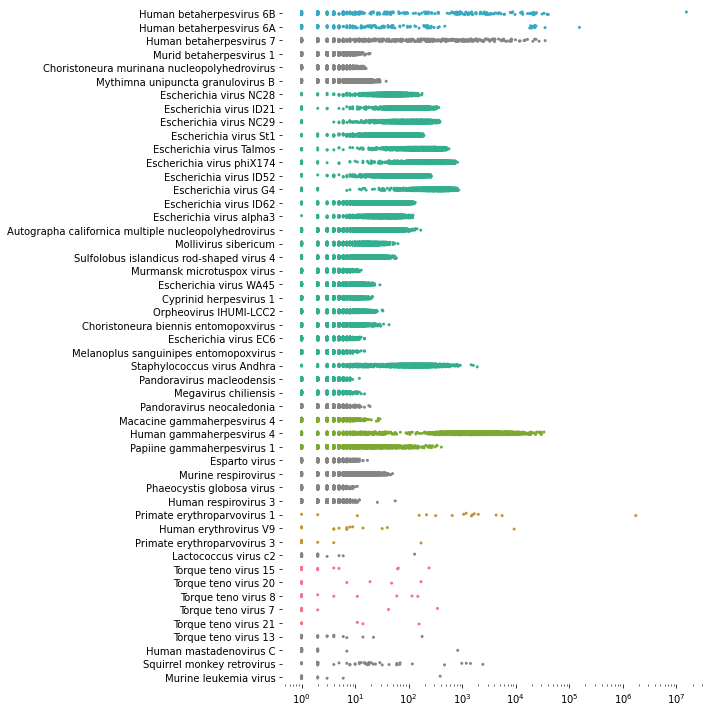

In [50]:
plt.figure(figsize=(10,10))
sns.stripplot(data=df_melt, y='variable', x='value', hue='color', jitter=.1, size=3)
plt.xscale('log')
plt.ylabel('')
plt.xlabel('')
ax = plt.gca()
ax.tick_params(axis='y', which='major', labelsize=10)
plt.box(on=None)
plt.legend().remove()
plt.tight_layout()
plt.savefig(fig_dir + 'virus_abundance_kraken_amia.png', transparent=True, bbox_inches='tight', format='png', dpi=500)

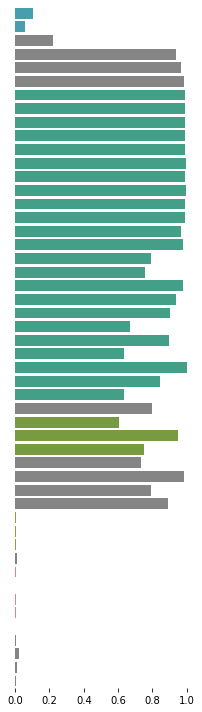

In [51]:
plt.figure(figsize=(3,10))
prevalence = pd.DataFrame((df_virus>0).mean(),columns=['prev'])
prevalence = prevalence.loc[virus_order[::-1]]
prevalence['microbe'] = prevalence.index
prevalence['color'] = [color_dict[v] for v in prevalence.microbe]
sns.barplot(data=prevalence, y='microbe', x='prev', hue='color', dodge=False)
plt.yticks([])
plt.ylabel('')
plt.xlabel('')
plt.legend().remove()
plt.box(on=None)
plt.tight_layout()
plt.savefig(fig_dir + 'virus_prevalence_kraken_amia.png', transparent=True, bbox_inches='tight', format='png', dpi=500)

# Bacteria

In [70]:
bacteria_abundant = df_bacteria.columns[np.argsort(df_bacteria.sum())[::-1]][1:51] # Drop homosapiens!
bacteria_prevalent = []#df_bacteria.columns[np.argsort((df_bacteria>0).sum())[::-1]][:100]
select_bacteria = list(set(bacteria_abundant).union(set(bacteria_prevalent)))
len(select_bacteria)

50

In [71]:
dists = 1-df_bacteria[select_bacteria].corr('spearman')#pdist(df_bacteria.transpose(), 'braycurtis')
linkage_mat = linkage(dists)
bacteria_order = list(df_bacteria[select_bacteria].columns[leaves_list(linkage_mat)])

/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


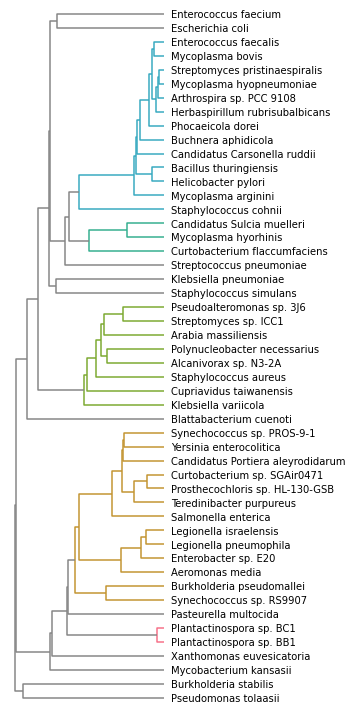

In [72]:
plt.figure(figsize=(5,10))
hierarchy.set_link_color_palette(palette)
dn2 = dendrogram(linkage_mat, orientation='left', labels=select_bacteria,color_threshold=0.6*np.max(linkage_mat[:,2]), above_threshold_color='#858585')
ax = plt.gca()
ax.tick_params(axis='y', which='major', labelsize=10)
plt.box(on=None)
plt.bbox_inches='tight'
plt.xticks([])
plt.tight_layout()
plt.savefig(fig_dir + 'bacteria_clusters_amia.png', transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()

In [74]:
#for v in bacteria_order[::-1]: print("'%s',"%v)


In [81]:
### Hacky way to get colors right ###
#for v in bacteria_order[::-1]: print("'%s',"%v)
# Bacteria that don't belong to a cluster (bottom to top)
loners = [
'Enterococcus faecium',
'Escherichia coli',
'Streptococcus pneumoniae',
'Klebsiella pneumoniae',
'Staphylococcus simulans',
'Blattabacterium cuenoti',
'Pasteurella multocida',
'Xanthomonas euvesicatoria',
'Mycobacterium kansasii',
'Burkholderia stabilis',
'Pseudomonas tolaasii',
]

palette_dict = {p:i for i,p in enumerate(['#858585'] + palette)}
color_count = Counter([palette_dict[d] for d in dn2['color_list']])
color = np.array([0 for i in bacteria_order])
i_start = 0
for c in range(1,len(color_count)):
    while bacteria_order[i_start] in loners:
        i_start = i_start + 1
    i_end = i_start + color_count[c] + 1
    color[i_start:i_end] = c
    i_start = i_end
color_dict = {i:j for i,j in zip(bacteria_order, color)}

In [82]:
sns.set_palette(['#858585'] + palette)
df_melt = pd.melt(df_bacteria[bacteria_order[::-1]])
df_melt = df_melt[df_melt.value>0]
df_melt['color'] = [color_dict[v] for v in df_melt.variable]

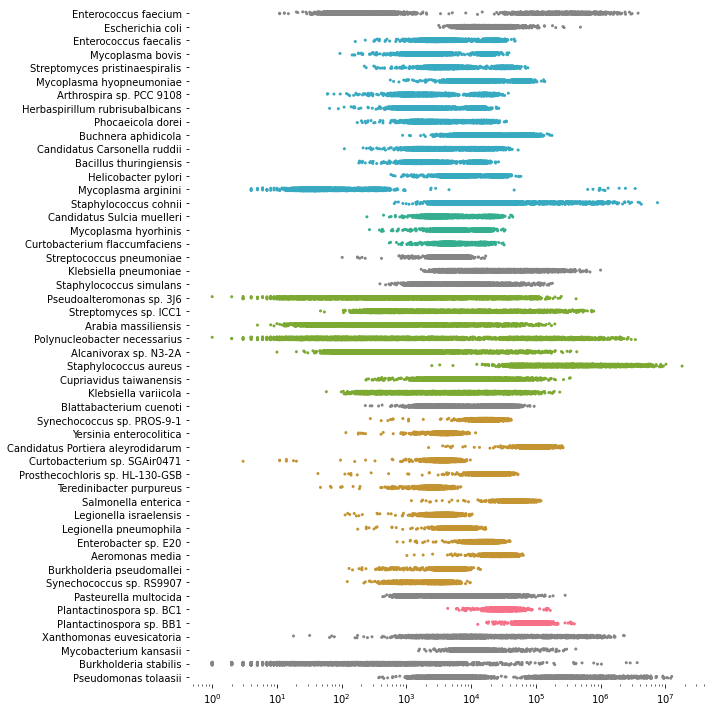

In [83]:
plt.figure(figsize=(10,10))
df_melt = pd.melt(df_bacteria[bacteria_order[::-1]])
df_melt = df_melt[df_melt.value>0]
df_melt = df_melt[df_melt.value>0]
df_melt['color'] = [color_dict[v] for v in df_melt.variable]
sns.stripplot(data=df_melt, y='variable', x='value', hue='color', jitter=.1, size=3)
plt.xscale('log')
plt.ylabel('')
plt.xlabel('')
ax = plt.gca()
ax.tick_params(axis='y', which='major', labelsize=10)
plt.box(on=None)
plt.legend().remove()
plt.tight_layout()
plt.savefig(fig_dir + 'bacteria_abundance_amia.png', transparent=True, bbox_inches='tight', format='png', dpi=500)

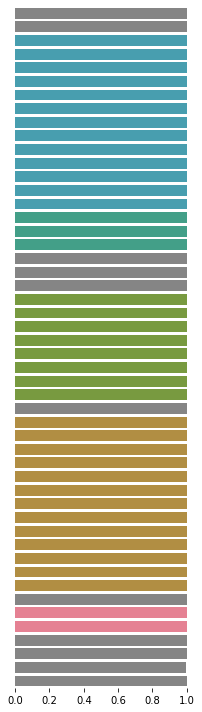

In [84]:
sns.set_palette(['#858585'] + palette)
plt.figure(figsize=(3,10))
prevalence = pd.DataFrame((df_bacteria>0).mean(),columns=['prev'])
prevalence = prevalence.loc[bacteria_order[::-1]]
prevalence['microbe'] = prevalence.index
prevalence['color'] = [color_dict[v] for v in prevalence.microbe]
sns.barplot(data=prevalence, y='microbe', x='prev', hue='color', dodge=False)
#plt.xscale('log')
plt.yticks([])
plt.ylabel('')
plt.xlabel('')
plt.legend().remove()
plt.box(on=None)
plt.tight_layout()
plt.savefig(fig_dir + 'bacteria_prevalence_amia.png', transparent=True, bbox_inches='tight', format='png', dpi=500)